### `chroma.ipynb`

This notebook indexes documents into a Chroma vector store using embedding models from Hugging Face.
Tools:
- Langchain
- Chroma
- Custom Loaders for Hugging Face and arXiv
- Custom Token Splitter (`TrainWiseTokenSplitter`) because the off-the-shelf ones of Langchain didn't work well (especially with arxiv documents)

You need to have a Hugging Face account to use the Inference API for embeddings.

In [19]:
import os
import sys
from dotenv import load_dotenv
from uuid import uuid4

from data.loaders import HuggingFaceBlogLoader, HuggingFaceDocsLoader, ArxivLoader
from data.utils import load_dataframe_from_sheet, get_docs

load_dotenv(override=True)

sys.path.append(os.path.abspath(".."))
FIRECRAWL_API_KEY = os.getenv("FIRECRAWL_API_KEY")
GOOGLE_SHEETS_ID = os.getenv("GOOGLE_SHEETS_ID")
GOOGLE_SHEETS_NAME = os.getenv("GOOGLE_SHEETS_NAME")
HF_TOKEN = os.getenv("HF_TOKEN")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load the documents dataframe

In [2]:
df = load_dataframe_from_sheet(GOOGLE_SHEETS_ID, GOOGLE_SHEETS_NAME)

### Load the documents using the custom Loaders (HF, arxiv)

In [3]:
hf_blogs_urls = get_docs(df, source="Hugging Face", doc_type="blog", urls_only=True)
hf_blogs_loader = HuggingFaceBlogLoader(firecrawl_api_key=FIRECRAWL_API_KEY, urls=hf_blogs_urls)
hf_blogs_docs = hf_blogs_loader.load()
hf_blogs_docs = hf_blogs_loader.clean(hf_blogs_docs)


Cleaning Hugging Face blogs: 100%|██████████| 5/5 [00:00<00:00, 4163.49it/s]


In [4]:
hf_docs_urls = get_docs(df, source="Hugging Face", doc_type="docs", urls_only=True)
hf_docs_loader = HuggingFaceDocsLoader(firecrawl_api_key=FIRECRAWL_API_KEY, urls=hf_docs_urls)
hf_docs_docs = hf_docs_loader.load()
hf_docs_docs = hf_docs_loader.clean(hf_docs_docs)

Cleaning Hugging Face docs: 100%|██████████| 23/23 [00:00<00:00, 4382.56it/s]


In [5]:
arxiv_urls = get_docs(df, source="arxiv", doc_type="paper", urls_only=True)
arxiv_loader = ArxivLoader(urls=arxiv_urls)
arxiv_docs = arxiv_loader.load()
arxiv_docs = arxiv_loader.clean(arxiv_docs)

Cleaning Arxiv papers: 100%|██████████| 3/3 [00:00<00:00, 603.53it/s]


In [7]:
all_docs = hf_blogs_docs + hf_docs_docs + arxiv_docs

print(f"Total documents loaded: {len(all_docs)}")

Total documents loaded: 31


### Split the documents into chunks using the custom TrainWiseTokenSplitter
We use the `nomic-ai/modernbert-embed-base`tokenizer but you can use any tokenizer you want.

In [8]:
from data.splitter import TrainWiseTokenSplitter
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("nomic-ai/modernbert-embed-base")
# tokenizer = AutoTokenizer.from_pretrained("jinaai/jina-embeddings-v2-base-code")
text_splitter = TrainWiseTokenSplitter(
    tokenizer = tokenizer,
    tokens_per_chunk = 1200,
    chunk_overlap = 200,
)
chunks = text_splitter.split_docs(all_docs)

Splitting documents into chunks: 100%|██████████| 31/31 [00:00<00:00, 68.01it/s] 


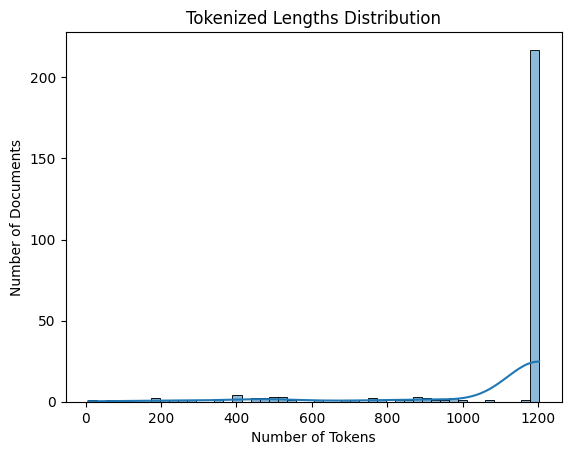

{'max_length': 1202, 'min_length': 7, 'average_length': 1100.095785440613}


In [10]:
from data.splitter import DocumentsTokensAnalysis
analyzer = DocumentsTokensAnalysis(tokenizer=tokenizer, docs=chunks)
analysis = analyzer.analyze(plot=True)
print(analysis)

### Load the Embedding model using Langchain HuggingFaceEndpointEmbeddings
Use your HF Token (I have a PRO subscription) to access the Inference API but they offer a fair amount of free calls as well.

In [37]:
from langchain_chroma import Chroma
from langchain_huggingface.embeddings import HuggingFaceEndpointEmbeddings


hf_embeddings = HuggingFaceEndpointEmbeddings(
    model= "nomic-ai/modernbert-embed-base",
    task="feature-extraction",
    huggingfacehub_api_token=HF_TOKEN,
)


### Indexing

In [38]:
from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="trainwise_collection",
    embedding_function=hf_embeddings,
    persist_directory="./chroma_db",
)

We need to batch the chunks because hf endpoint has rate limits.

In [31]:
uuids = [str(uuid4()) for _ in range(len(chunks))]
for doc, idx in zip(chunks, uuids):
    doc.metadata["id"] = idx

In [39]:
for doc in chunks:
    if doc.metadata.get("id", None) is None:
        print("Missing ID in metadata")

In [40]:
def batch(iterable, size=16):
    for i in range(0, len(iterable), size):
        yield iterable[i:i + size]

BATCH_SIZE = 16

for chunk_batch in batch(chunks, BATCH_SIZE):
    vector_store.add_documents(chunk_batch, ids=[doc.metadata["id"] for doc in chunk_batch])
    print([doc.metadata["id"] for doc in chunk_batch])

['a293f0c6-c0f0-40e9-9b92-217fa52de88b', '758180e9-ce8f-411c-8c71-d9bfcee7e78e', '54c84abb-bb9f-4e00-bb84-73f29aa4a597', '26a3d8aa-c862-493f-9755-0ece23ba51d8', '175018a5-6aac-4c2e-ae24-c43c6217e084', '655adef1-8b80-4f36-86fe-6ffded595539', 'c6df6429-658c-4da8-833d-38bee693e51a', 'bd828637-da6f-44e8-9da4-76f0094db021', '151b4a25-d52c-4c4e-a53c-acb8cd49c0ab', '9751c145-6a9a-4d9b-b3e0-73389fa92cac', '4240908a-1f73-44ba-b619-88183a60c113', '97caf57e-f1c8-41d7-8736-7436f6602c48', '0ada8313-dd3f-4d4a-bff6-4661fd7a3e23', 'ee2af045-6c0c-4353-872d-24ca85b01e59', '3def1580-3218-478a-a468-19d93d3001de', '20516574-6700-4e2d-b096-86bc1167aed1']
['cf715bc0-0813-4fe3-81cc-6e925eb40058', '5626a29b-1dc6-4f90-8c04-f11123b869ec', '6331060c-032f-47c2-af44-1b8a4448873c', 'd7a47474-572e-4dff-9ea9-70bc74bd5e1e', '6ef3be74-0d2f-4048-8728-d169f7809e43', '3480e5c6-ab7f-489c-a482-ed0c486aeb20', 'f170069b-6dc0-42d2-ad33-47b9eab2fbb5', '89852c94-3529-43b1-b9e1-176ae5af8272', 'f232112c-4b20-4fd4-ba55-c135aee48bb4'

Persist the chunks to a JSONL file for later use.

In [41]:
from langchain_core.load.dump import dumps

jsonl_data = "\n".join([dumps(chunk) for chunk in chunks])

with open("../chunks.jsonl", "w", encoding="utf-8") as f:
    f.write(jsonl_data)


### Usage Example
find similar documents with a filter on the source metadata field

In [42]:
results = vector_store.similarity_search(
    "What is LoRA??",
    k=5,
    filter={"source": "hf"}
)
for res in results:
    # print(f"* {id(res)}: {res.page_content[:200]} [{res.metadata}]")
    print(res.metadata.get("id", "No ID"))


cda0438d-5520-476e-a218-7aaab8de8ac9
b0e1d2ce-c63b-49ca-b225-ff5a68d3bf72
30257a46-2b93-47c0-9c25-c2356f40edf8
e9ed14a6-b20b-44c9-9a8f-7dc7102d329d
64feea19-c64d-4a99-a763-eccecbb89b27
